In [3]:
import numpy as np
from scipy.linalg import inv
import matplotlib.pyplot as plt
%matplotlib inline

from typhon.plots import profile_p, profile_z, styles
from typhon.arts import xml
from typhon.physics import frequency2wavenumber
plt.style.use(styles.get('typhon'))

In [8]:
project_name = "dropsonde_testcase_2020-01-24"
project_path = f"/Users/mprange/PycharmProjects/iasi_retrieval/{project_name}"

p_grid = xml.load(f"{project_path}/a_priori/a_priori_p.xml")
z_grid = xml.load(f"{project_path}/a_priori/a_priori_z.xml")

a_priori_vmr = xml.load(f"{project_path}/a_priori/a_priori_vmr.xml")
a_priori_t = xml.load(f"{project_path}/a_priori/a_priori_temperature.xml")

true_atm_fields = xml.load(f"{project_path}/observations/dropsonde_eresmaa_profile.xml")
true_y = xml.load(f"{project_path}/observations/dropsonde_eresmaa_profile_1190_1400_2150_2400_cm-1.xml")
true_jacobian = xml.load(f"{project_path}/observations/"
                        "dropsonde_eresmaa_profile_1190_1400_2150_2400_cm-1_jacobian.xml")
true_vmr = true_atm_fields[0][6][:,0,0]
true_t = true_atm_fields[0][0][:,0,0]

retrieved_vmr = xml.load(f"{project_path}/retrieval_output/retrieved_h2o_vmr.xml")
retrieved_t = xml.load(f"{project_path}/retrieval_output/retrieved_temperature.xml")
retrieved_ts = xml.load(f"{project_path}/retrieval_output/retrieved_surface_temperature.xml")
retrieved_y = xml.load(f"{project_path}/retrieval_output/retrieved_y.xml")
retrieved_jacobian = xml.load(f"{project_path}/retrieval_output/retrieved_jacobian.xml")

f_backend = xml.load(f"{project_path}/sensor/f_backend.xml")
k_grid = frequency2wavenumber(f_backend)

cov_h2o = xml.load(f"{project_path}/a_priori/covariance_H2O, H2O-SelfContCKDMT252, H2O-ForeignContCKDMT252.xml")
cov_t = xml.load(f"{project_path}/a_priori/covariance_T.xml")
cov_y = xml.load(f"{project_path}/sensor/covariance_y.xml")
cov_x = xml.load(f"{project_path}/a_priori/covmat_sx.xml")

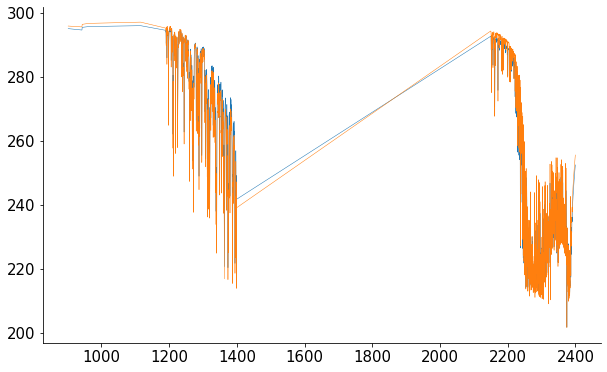

In [27]:
plt.plot(k_grid / 100, true_y[0], linewidth=0.5)
plt.plot(k_grid / 100, true_y[1], linewidth=0.5)

In [5]:
# Averaging Kernel
def averaging_kernel(K, Sa, Sy):
    return inv(K.T @ inv(Sy) @ K + inv(Sa)) @ K.T @ inv(Sy) @ K

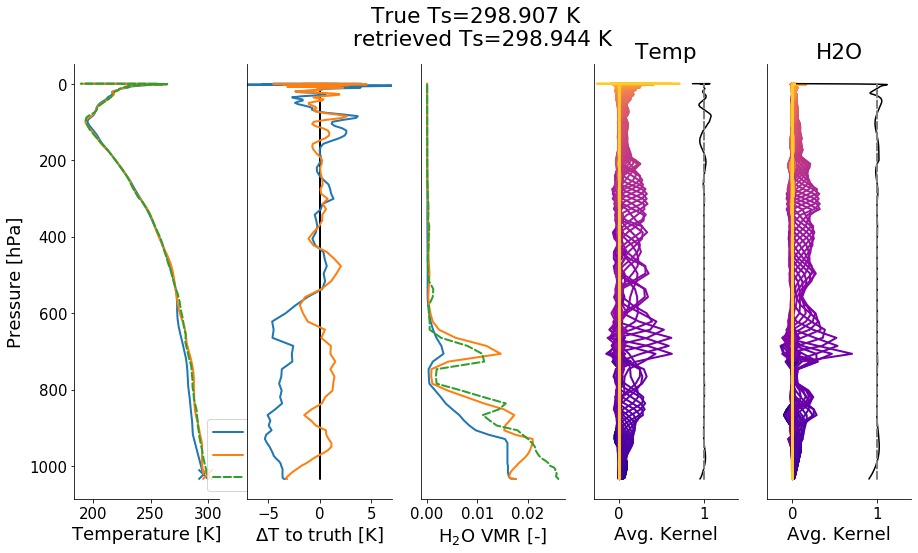

In [9]:
for ind in range(0, 1):
    ret_ind = np.copy(ind)
    true_ind = np.copy(ind)
    fig, axs = plt.subplots(ncols=5, figsize=(15, 8))
    colormap = plt.cm.plasma
    profile_p(p_grid, a_priori_t[:,0,0], label="a priori", ax=axs[0])
    profile_p(p_grid, retrieved_t[ret_ind], label="retrieved", ax=axs[0], )
    profile_p(p_grid, true_atm_fields[true_ind][0][:,0,0], label="truth", ax=axs[0], linestyle="--")
    axs[0].set_xlabel("Temperature [K]")

    profile_p(p_grid, np.zeros(len(p_grid)), label="retrieved", ax=axs[1], color="k")
    profile_p(p_grid, a_priori_t[:,0,0] - true_atm_fields[true_ind][0][:,0,0], 
              color="#1f77b4", label="a priori", ax=axs[1])
    profile_p(p_grid, retrieved_t[ret_ind] - true_atm_fields[true_ind][0][:,0,0], 
              color="#ff7f0e", label="retrieved", ax=axs[1])
    axs[1].set_xlim([-7, 7])
    axs[1].set_xlabel("$\Delta$T to truth [K]")

    profile_p(p_grid, a_priori_vmr[0,:,0,0], label="a priori", ax=axs[2])
    profile_p(p_grid, retrieved_vmr[ret_ind], label="retrieved", 
              ax=axs[2])
    profile_p(p_grid, true_atm_fields[true_ind][6][:,0,0], label="truth", ax=axs[2], linestyle="--")
    axs[0].scatter(a_priori_t[0,0,0], p_grid[0], marker="x", s=100, linewidths=10)
    axs[0].scatter(retrieved_ts[ret_ind], p_grid[0], marker="x", s=100, linewidths=10)
    plt.suptitle(f"True Ts={np.round(true_atm_fields[true_ind][0][0,0,0], 3)} K \n "
                 f"retrieved Ts={np.round(retrieved_ts[ret_ind][0, 0], 3)} K")
    axs[2].set_xlabel("H$_2$O VMR [-]")
    axs[0].legend()

    A = averaging_kernel(retrieved_jacobian[ret_ind][:,1:139], cov_t, cov_y)
    axs[3].set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 0.9, len(A))])
    axs[3].set_xlim([-0.3, 1.4])
    for irow in range(len(A)):
        profile_p(p_grid, A[irow,:], ax=axs[3])
    profile_p(p_grid, np.sum(A[:,:], axis=1), ax=axs[3], color="black", linewidth=1.5)
    profile_p(p_grid, np.ones(len(p_grid)), linestyle="--", color="gray", ax=axs[3])
    #axs[3].set_ylim([0, 2.e4])
    axs[3].set_title("Temp")
    axs[3].set_xlabel("Avg. Kernel")


    A = averaging_kernel(retrieved_jacobian[ret_ind][:,139:], cov_h2o, cov_y)
    axs[4].set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 0.9, len(A))])
    axs[4].set_xlim([-0.3, 1.4])
    for irow in range(len(A)):
        profile_p(p_grid, A[irow,:], ax=axs[4])
    profile_p(p_grid, np.sum(A[:,:], axis=1), ax=axs[4], color="black", linewidth=1.5)
    profile_p(p_grid, np.ones(len(p_grid)), linestyle="--", color="gray", ax=axs[4])
    #axs[4].set_ylim([0, 2.e4])
    axs[4].set_title("H2O")
    axs[4].set_xlabel("Avg. Kernel")


    axs[0].legend(bbox_to_anchor=(0.87, 0.2))
    axs[1].axes.get_yaxis().set_visible(False)
    axs[2].axes.get_yaxis().set_visible(False)
    axs[3].axes.get_yaxis().set_visible(False)
    axs[4].axes.get_yaxis().set_visible(False)
    # [axs[i].set_ylim([p_grid[0], 2e4]) for i in range(5)]

plt.savefig(f"{project_path}/plots/retrieval_profiles_eresmaa1_apriori.pdf")

In [16]:
(true_vmr[] - a_priori_vmr).shape

(5, 138, 1, 138)

In [15]:
A = averaging_kernel(retrieved_jacobian[0][:,139:], cov_h2o, cov_y)
plt.figure()
profile_p(p_grid, A @ (true_vmr - a_priori_vmr))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 138)

<Figure size 720x444.96 with 0 Axes>

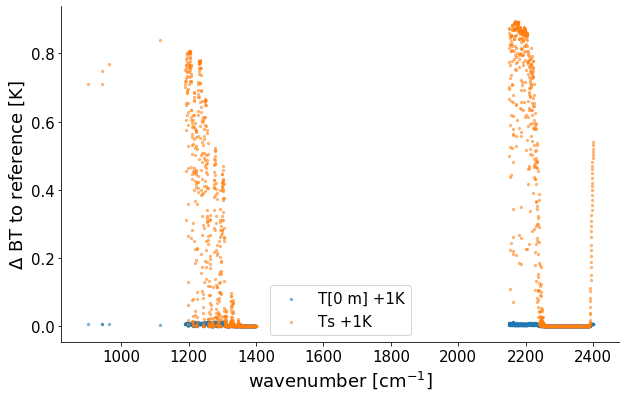

In [123]:
ref_y = xml.load(project_path + "/retrieval_output/y_reference.xml")
atm_pert_y = xml.load(project_path + "/retrieval_output/y_lowest_atm_layer_plus1K.xml")
Ts_pert_y = xml.load(project_path + "/retrieval_output/y_t_surface_plus1K.xml")

plt.scatter(k_grid / 100, atm_pert_y - ref_y, s=5, label="T[0 m] +1K", alpha=0.5)
plt.scatter(k_grid / 100, Ts_pert_y - ref_y, s=5, label="Ts +1K", alpha=0.5)
plt.legend()
plt.xlabel("wavenumber [cm$^{-1}$]")
plt.ylabel("$\Delta$ BT to reference [K]")
plt.savefig(project_path + "/plots/delta_tb_for_dtatm0_vs_dts.pdf")

In [7]:
Sa_T = xml.load(project_path +
                "/a_priori/covariance_T.xml")
Sa_h2o = xml.load(project_path + 
                  "/a_priori/covariance_H2O, H2O-SelfContCKDMT252, H2O-ForeignContCKDMT252.xml")
Sx = np.block([
    [Sa_T, np.zeros(Sa_T.shape)], 
    [np.zeros(Sa_T.shape), Sa_h2o]])

S = np.zeros(Sa_T.shape)
S[np.diag_indices_from(S)] = [np.sqrt(Sx[0, 0] * Sx[43, 43]) * np.exp(-1 / 1500 * z_grid[i] ) for i in range(43)]

cl = corr_length_cov(z_grid)
for i in range(S.shape[1]):
    for j in range(S.shape[0]):
        cl_mean = (cl[i] + cl[j]) / 2
        s = (S[j, j] + S[i, i]) / 2
        S[i, j] = s * np.exp(-np.abs(z_grid[i] - z_grid[j]) / cl_mean)

#Sx[i, j] = np.exp(-1500 * z_grid[])
Sx = np.block([
    [Sa_T, S], 
    [S, Sa_h2o]])



In [14]:
np.block([
    [Sa_T, np.zeros(Sa_T.shape), np.zeros((43, 1))],
    [np.zeros(Sa_T.shape), Sa_T, np.zeros((43, 1))],
    [np.zeros((1, 43)), np.zeros((1, 43)), np.array([[100]])]
]).shape

(87, 87)

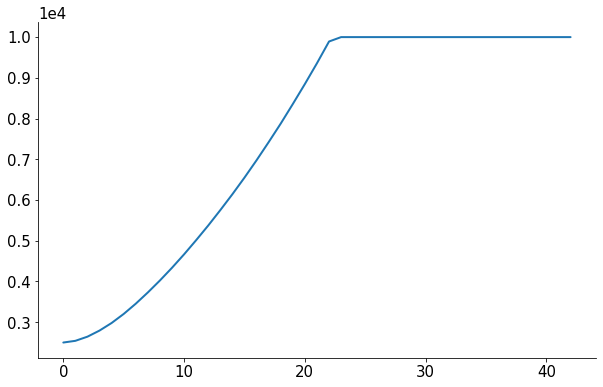

In [4]:
def corr_length_cov(z, trpp=12.5e3):
    """Return correlation lengths for given altitudes.
    Parameters:
        z (np.array): Height levels [m]
        trpp (float): Tropopause height [m]

    Returns:
        np.array: Correlation length for each heigth level.

    """
    f = np.poly1d(np.polyfit(x=(0, trpp), y=(2.5e3, 10e3), deg=1))
    cl = f(z)
    cl[z > trpp] = 10e3

    return cl
plt.plot(corr_length_cov(z=z_grid))

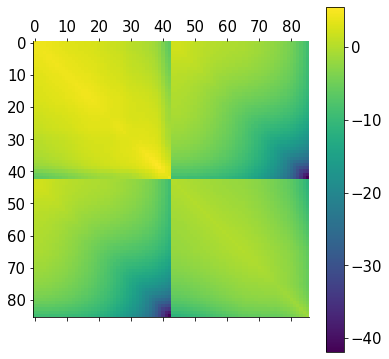

In [33]:
a = plt.matshow(np.log(Sx))
plt.colorbar(a)

ValueError: too many values to unpack (expected 2)

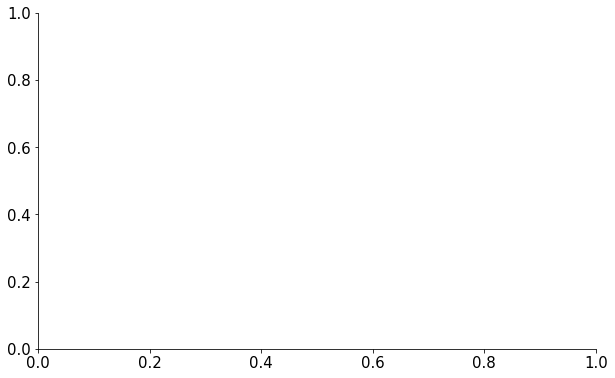

In [41]:
fig, ax = plt.subplots(nrows=1, sharex=True)
mesh = ax.pcolormesh(k_grid/100, p_grid/100,
              true_jacobian[0][:,:43].T ,
              cmap="seismic",
              norm=MidpointNormalize(midpoint=0, vmin=-1, vmax=1),
              )
ax.invert_yaxis()
ax.set_xlabel("wavenumber [cm$^{-1}$]")
ax.set_ylabel("pressure [hPa]")
fig.colorbar(mesh,ax=ax, label="[K/K]")
ax.set_title("T Jacobian")
ax.set_ylim([1013, 800])
#plt.savefig(project_path + "/plots/retrieved_temperature_jacobian_only_T_retrieved.pdf")

fig, ax = plt.subplots(nrows=1, sharex=True)
mesh = ax.pcolormesh(k_grid/100, p_grid/100,
              true_jacobian[0][:,43:].T ,
              cmap="seismic",
              norm=MidpointNormalize(midpoint=0),
              )
ax.invert_yaxis()
ax.set_xlabel("wavenumber [cm$^{-1}$]")
ax.set_ylabel("pressure [hPa]")
fig.colorbar(mesh,ax=ax, label="[K/100%VMR]")
ax.set_title("H2O Jacobian")
#plt.savefig(project_path + "/plots/true_h2o_vmr_jacobian_only_T_retrieved.pdf")

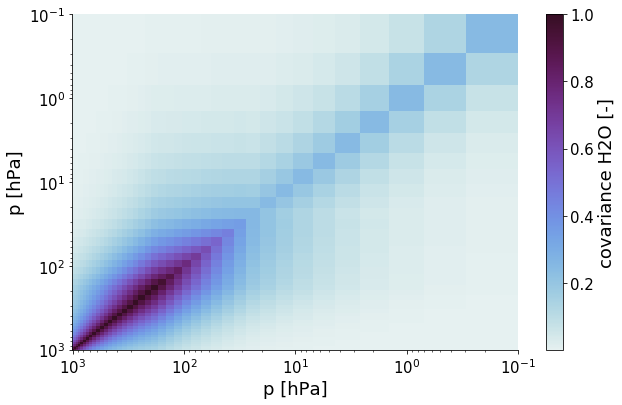

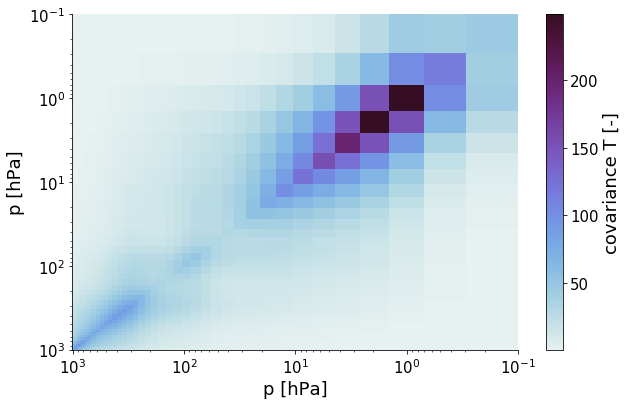

In [7]:
fig, ax = plt.subplots()
mesh = ax.pcolormesh(p_grid / 100, p_grid / 100,
              Sx,
              cmap="density",
              #norm=MidpointNormalize(midpoint=0),
              )
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel("p [hPa]")
ax.set_ylabel("p [hPa]")
fig.colorbar(mesh, label="covariance H2O [-]")
#plt.savefig("/scratch/uni/u237/users/mprange/phd/iasi_retrieval/plots/cov_h2o.pdf")

fig, ax = plt.subplots()
mesh = ax.pcolormesh(p_grid / 100, p_grid / 100,
              cov_t,
              cmap="density",
              #norm=MidpointNormalize(midpoint=0),
              )
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel("p [hPa]")
ax.set_ylabel("p [hPa]")
fig.colorbar(mesh, label="covariance T [-]")
plt.savefig("/scratch/uni/u237/users/mprange/phd/iasi_retrieval/plots/cov_t.pdf")

In [40]:
import matplotlib.colors as colors
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

1

Text(0, 0.5, 'z [km]')

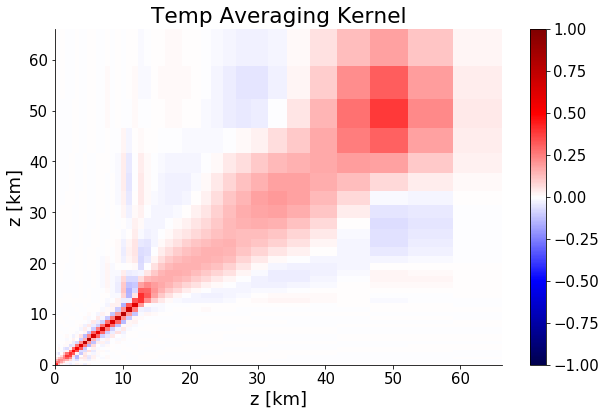

In [58]:
A = averaging_kernel(retrieved_jacobian[0][:,43:], cov_h2o, cov_y)

fig, ax = plt.subplots(nrows=1, sharex=True)
mesh = ax.pcolormesh(z_grid / 1000, z_grid / 1000,
              A,
              cmap="seismic",
              norm=MidpointNormalize(midpoint=0, vmin=-1, vmax=1),
              )
fig.colorbar(mesh,ax=ax)
ax.set_title("Temp Averaging Kernel")
ax.set_xlabel("z [km]")
ax.set_ylabel("z [km]")
#plt.savefig(f"{project_path}/plots/T_averaging_kernel_contour.pdf")

(0, 10000.0)

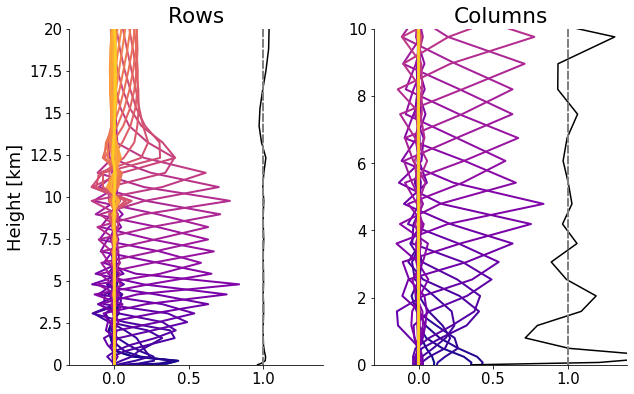

In [61]:
fig, axs = plt.subplots(ncols=2)
colormap = plt.cm.plasma
#rows
axs[0].set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 0.9, len(A))])
axs[0].set_title("Rows")
axs[0].set_xlim([-0.3, 1.4])
for irow in range(len(A)):
    profile_z(z_grid, A[irow,:], ax=axs[0])
profile_z(z_grid, np.sum(A[:,:], axis=1), ax=axs[0], color="black", linewidth=1.5)
profile_z(z_grid, np.ones(len(p_grid)), linestyle="--", color="gray", ax=axs[0])
axs[0].set_ylim([0, 2.e4])
#columns
axs[1].set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 0.9, len(A))])
axs[1].set_title("Columns")
axs[1].set_xlim([-0.3, 1.4])
for icol in range(len(A)):
    profile_z(z_grid, A[:,icol], ax=axs[1])
profile_z(z_grid, np.sum(A[:,:], axis=0), ax=axs[1], color="black", linewidth=1.5)
profile_z(z_grid, np.ones(len(p_grid)), linestyle="--", color="gray", ax=axs[1])
#plt.savefig(f"{project_path}/plots/h2o_averaging_kernel_rows_columns.pdf")
axs[1].set_ylim([0, 1e4])

